In [2]:
import os
import logging

# compute
import numpy as np

# interpolation and triangulation
import scipy.interpolate
import scipy.spatial
import matplotlib.tri

import plyfile

# colormapping
import matplotlib.cm
import matplotlib.colors

# interact
from ipywidgets import interact

import matplotlib.pyplot as plt
%matplotlib inline

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.root.handlers.clear()
logging.basicConfig()

In [3]:
filename = '6400x4800, zonder zandmotor.xyz'
# replaced filename by my local copy
filename = os.path.expanduser('~/Downloads/6650x5000, zonder zandmotor.xyz')
xyz = np.loadtxt(filename)

In [4]:
# we need a few extra points around the edge so we know that we have a square
# define an interpolation function
L = scipy.interpolate.NearestNDInterpolator(xyz[:,:2], xyz[:,2])
xmin = xyz[:,0].min()
xmax = xyz[:,0].max()
ymin = xyz[:,1].min()
ymax = xyz[:,1].max()

Y, X = np.mgrid[(ymin-20):(ymax+20):100, (xmin-20):(xmax+20):2j]
xy_extra = np.c_[X.ravel(), Y.ravel()]
# create a xyz
xyz_extra = np.hstack((xy_extra, L(xy_extra)[:,np.newaxis]))
# append to xyz
xyz = np.vstack((xyz, xyz_extra))

Y, X = np.mgrid[(ymin-20):(ymax+20):2j, (xmin-20):(xmax+20):100]
xy_extra = np.c_[X.ravel(), Y.ravel()]
# create xyz
xyz_extra = np.hstack((xy_extra, L(xy_extra)[:,np.newaxis]))
# append to xyz
xyz = np.vstack((xyz, xyz_extra))

In [5]:
# convert from world to engineering coordinates (our local sandbox)
# also cleanup and rescale vertical > 0 different from vertical < 0
def x2bak(x):
    # from 0,6400m to 1.28m
    result = (x/6400.)*1.28
    return result
def y2bak(y):
    # from 0,4800m to 1m
    result = (y/4800.)*.96
    return result
def z2bak(z):
    # chop
    z[z < -12] = -12.
    z[z > 0] *= .5
    z[z > 12] = 12.
    
    # raise to 0
    z -= -12
    
    # from 0,24m to 0.20m
    result = (z/24.)*0.2
    return result

xyz_scaledd = np.c_[
    x2bak(xyz[:,0].copy()),
    y2bak(xyz[:,1].copy()),
    z2bak(xyz[:,2].copy())
]

# remove all the points lower than 1 mm
# xyz_scaled = xyz_scaled[xyz_scaled[:,2]>.001]

In [6]:
# remove all the points lower than 1 mm

bigger_than_1mm = xyz_scaledd[:,2]>.01
xyz_scaled = np.zeros((np.sum(bigger_than_1mm), 3))

xyz_scaled[:,0] = xyz_scaledd[:,0][bigger_than_1mm]
xyz_scaled[:,1] = xyz_scaledd[:,1][bigger_than_1mm]
xyz_scaled[:,2] = xyz_scaledd[:,2][bigger_than_1mm]

In [7]:
# define a triangular mesh
tri = matplotlib.tri.Triangulation(xyz_scaled[:,0], xyz_scaled[:,1])

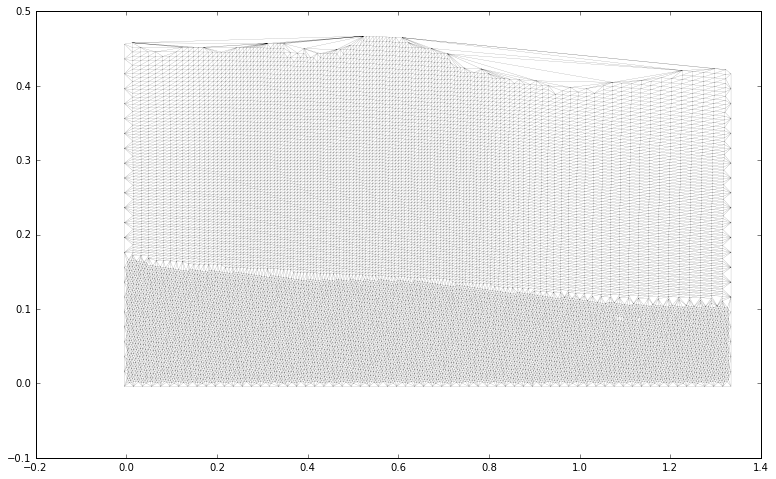

In [8]:
# this should look somewhat regular, it's the basis for the mesh
fig, ax = plt.subplots(figsize=(13, 8))
_ = ax.triplot(tri, 'k-', linewidth=0.1)

In [9]:
# rescale z to 0,1 for computing colors
N = matplotlib.colors.Normalize(xyz[:,2].min(), xyz[:,2].max())
N = matplotlib.colors.Normalize(0, .2)

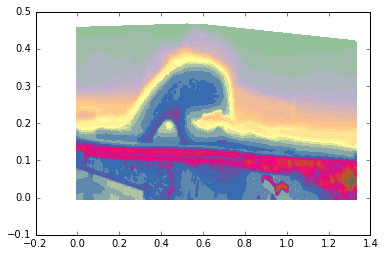

In [10]:
# these are the properties of the layers that we need to mill
t_wood = .006 # thickness of the wood
# vertical levels (in steps of thickness of wood)
V = np.arange(0, 0.2+t_wood, t_wood)
contours = plt.tricontourf(tri, xyz_scaled[:,2], V, cmap='Accent')

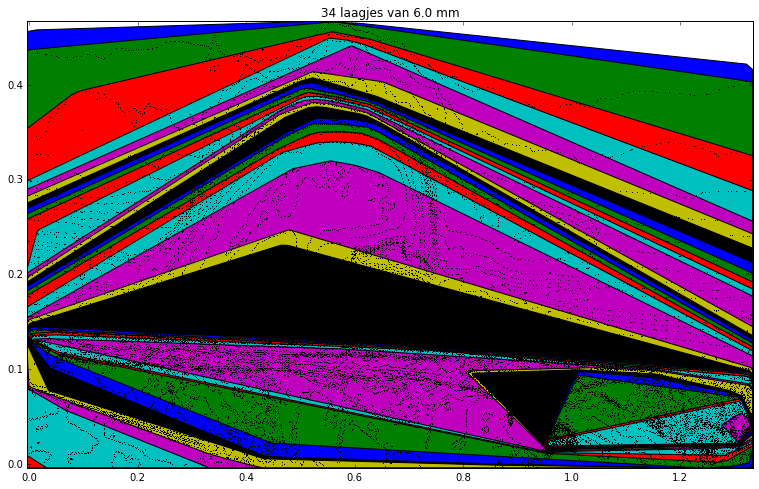

In [27]:
plt.subplots(figsize=(13, 8))

conpoints = []
for i, (v, segment) in enumerate(zip(V, contours.allsegs)):
    if len(segment) != 1:
        logger.warning('expected len segment 1 for segment %s', i)
    contour = segment[0]

    if not len(contour):
        logger.warning('no points in segment %s, skipping', i)
        continue

    # get the coordinates
    # compute a convex hull    
    hull = scipy.spatial.ConvexHull(contour)
    hull_points = hull.points[hull.vertices]
    
    # plot it
    plt.plot(contour[:,0], contour[:,1], 'k.', alpha=1, markersize=1)
    plt.fill(hull_points[:,0], 
             hull_points[:,1], 
             label='layer '+str(i))
# plt.legend()
plt.xlim(xyz_scaled[:, 0].min(), xyz_scaled[:, 0].max())
plt.ylim(xyz_scaled[:, 1].min(), xyz_scaled[:, 1].max())
plt.title(str(len(V)-1) + ' laagjes van ' + str(t_wood*1000) + ' mm');    

<function __main__.plot>

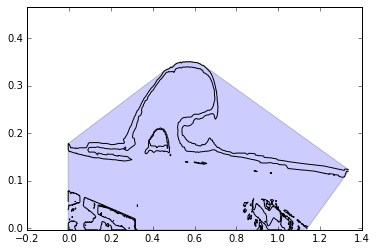

In [68]:
def plot(layer):
    x_domain = xyz_scaled[:, 0].min(), xyz_scaled[:, 0].max()
    contour = contours.allsegs[layer][0]
    kinds = contours.allkinds[layer][0]

    hull = scipy.spatial.ConvexHull(contour)
    hull_points = hull.points[hull.vertices]
    y_domain = contour[:,1].min(), contour[:,1].max()
    
    # add some points to the bottom
    # convert to list so we can add points
    contour_with_points = list(contour)
    
    
    
    plt.fill(hull_points[:,0], hull_points[:,1], alpha=0.2)
    for part in np.split(contour, np.nonzero(kinds == 1)[0]):
        plt.plot(part[:,0], part[:,1], 'k-')
    plt.xlim()
    plt.ylim(xyz_scaled[:, 1].min(), xyz_scaled[:, 1].max())

interact(plot, layer=(0, len(V)-1))

56

In [28]:
def plot(n):
    plt.plot(conpoints[n][:, 0], conpoints[n][:, 1])
    plt.xlim(0, 1.28)
    plt.ylim(0, .5)
    plt.title('hoogte = ' + str(conpoints[n][0, 2]))

interact(plot, n=(0, len(conpoints)-1, 1))

ValueError: max must be greater than min: (min=0, max=-1)

In [ ]:
# conpoints = conpoints[:50]

In [ ]:
copo1 = conpoints[0].copy()
copo2 = conpoints[0].copy()
copo2[:, 2] = 0
copo = np.vstack((copo1, copo2))
for i in range(1, len(conpoints)):
    copo = np.vstack((copo, conpoints[i]))

In [ ]:
tri = matplotlib.tri.Triangulation(copo[:,0], copo[:,1])
_ = plt.triplot(tri)

In [ ]:
N = matplotlib.colors.Normalize(0, .2)

In [ ]:
# see https://github.com/dranjan/python-plyfile
# compute vertex array (bit of hack with the tulpes)
vertex = np.array([
        tuple(row) 
        for row
        in copo.tolist()
    ], dtype=[
        ('x', 'f4'),
        ('y', 'f4'),
        ('z', 'f4')
    ])

# create a list of tuples followed by red,green,blue
facelist = []
for triangle in tri.triangles:
    z_triangle = copo[triangle[0], 2]
    r, g, b, a = matplotlib.cm.gist_earth(N(z_triangle), bytes=True)
    facelist.append((triangle, r, g, b))
    
face = np.array(facelist,
                dtype=[
        ('vertex_indices', 'i4', (3,)),
        ('red', 'u1'), ('green', 'u1'),
        ('blue', 'u1')
    ])

In [ ]:
ply = plyfile.PlyData([
        plyfile.PlyElement.describe(
                vertex, 'vertex',
                comments=['tetrahedron vertices']
        ),
        plyfile.PlyElement.describe(face, 'face')
    ],
    text=True, 
    byte_order='=',
    comments=['single tetrahedron with colored faces']
)
ply.write('filename.ply')

In [ ]:
print(conpoints[-3])